The purpose of this notebook is to test and compare a couple different methods for examining what parts of an image a CNN thinks are indicative of a particular class, mostly for my own edification.

The first is very simple, taken from *Learning Deep Features for Discriminative Localization*, Zhou et al., CVPR 2016. Basically, one takes a classifier with a GAP layer at the end (prior to the FC layer), and doesn't perform pooling. This creates $N$ downsampled images (one per class), which are effectively heatmaps of which regions of the image the network thinks are associated with that class. A big advantage here is that we only require a single forward pass to produce activation maps for every class. Additionally, this is very simple; you can take any existing network and just remove one layer. The biggest downside is that, obviously, one can only use this on networks with a GAP layer (e.g., not VGG models), but most of the state of the art modules have this (Inception, ResNet, etc.). More importantly, I have been told by people in the know that there are better ways to do this, like excitation backprop.

Excitation backprop, specified in *Top-down Neural Attention by Excitation Backprop*, Zhang et al., arXiv:1608.00507v, essentially involves specifying a probability distribution over the output classes, and propagating this back through the layers, using the layer response as a conditional probability and ensuring that we always have well defined (i.e., normalized) probability distribution at all steps. Most importantly, it does this is a constrastive way which difference the backprop of the distribution you want (e.g., "tabby cat") with the dual (e.g., "not tabby cat").

In [1]:
from eb_layers import get_eb_toggle, excitation_backprop
import imagenet_utils
from matplotlib import pyplot as plt
import numpy as np
from skimage import transform
import torch
import torchvision
from torchvision.models import resnet
import torch.utils.model_zoo as model_zoo

We'll look at ResNet-101: it's reasonably SotA, has GAP, and most importantly, comes out of the box in PyTorch.

In [2]:
model = torchvision.models.resnet101(pretrained=True)
model = model.eval()
idx_to_label, label_to_idx = imagenet_utils.get_imagenet_labels()
toggle_eb = get_eb_toggle()

For the no-GAP test, we'll need to modify the default ResNet so that the forward pass doesn't perform the pooling. Easiest way to do this is to subclass PyTorch's implementation. Sadly, we can't just set the pool layer to `None`, since there is also a re-shaping of the tensor to 2D in the forward pass code which we need to avoid.

A little clunky, but it get's the job done.

In [3]:
class ResNetNoGAP(resnet.ResNet):
    def __init__(self, block, layers, num_classes=1000):
        super().__init__(block, layers, num_classes=num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.permute(0, 2, 3, 1)
        x = self.fc(x)
        x = x.permute(0, 3, 1, 2)

        return x
    
model_no_GAP = ResNetNoGAP(resnet.Bottleneck, [3, 4, 23, 3])
model_no_GAP.load_state_dict(model_zoo.load_url(resnet.model_urls['resnet101']))
model_no_GAP = model_no_GAP.eval()

Finally, we'll implement some helper functions to visualize the predictions of the network and the results of both types of attention modeling.

In [4]:
def imagenet_test(model, image_path):
    test_image, real_image = imagenet_utils.load_image(image_path)
    with torch.no_grad():
        predictions = model(test_image[None, :])[0, :].cpu()
    predictions = predictions.exp()
    predictions /= predictions.sum()
    
    class_probs, class_idxs = predictions.topk(5)
    cell_text = [['%.1f%%' % (100*x) for x in class_probs]]
    class_labels = [idx_to_label(x) for x in class_idxs]
    
    plt.figure(figsize=(6,6))
    plt.imshow(real_image)
    plt.axis('off')
    table = plt.table(cellText=cell_text, colLabels=class_labels,
                      loc='right')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(2, 2)
    plt.show()
    
def no_GAP_test(model, image_path, class_label):
    cls_idx = label_to_idx(class_label)
    test_image, _ = imagenet_utils.load_image(image_path)
    real_image = imagenet_utils.imagenet_deprocess(test_image)
            
    with torch.no_grad():
        predictions = model(test_image[None, :])[0, :].cpu()
    class_map = predictions[cls_idx, :].numpy()
    class_map -= class_map.min()
    class_map /= class_map.max()
    class_map = transform.resize(class_map, real_image.size, order=3, mode='constant')
    plt.imshow(real_image)
    plt.imshow(class_map, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()
    
def eb_test(model, image_path, class_label, contrastive=True, target_layer=0):
    cls_idx = label_to_idx(class_label)
    output_prob = torch.zeros(1, 1000)
    output_prob.data[:, cls_idx] = 1
    test_image, _ = imagenet_utils.load_image(image_path)
    real_image = imagenet_utils.imagenet_deprocess(test_image)
    test_image = test_image[None, :]
            
    toggle_eb()
    eb_image = excitation_backprop(model, test_image, output_prob, contrastive=contrastive, 
                                   target_layer=target_layer)
    toggle_eb()
    eb_map = torch.sum(eb_image.clamp(min=0), (0, 1))
    eb_map = eb_map.cpu().detach().numpy()
    if eb_map.max() > 0:
        eb_map /= eb_map.max()
    eb_map = transform.resize(eb_map, real_image.size, order=3, mode='constant')
    plt.imshow(real_image)
    plt.imshow(eb_map, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()

Now, let's just visualize the network outputs on a sample image.

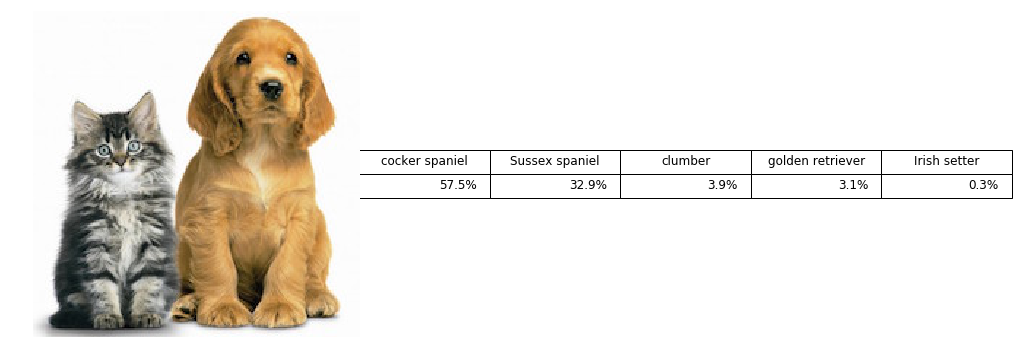

In [5]:
image_path = './data/catdog.jpg'
imagenet_test(model, image_path)

This is a great example, because that classification is correct (there is indeed a cocker spaniel in this image), but missing an important piece of information (there is a cat, too). In fact, the top 5 predictions are all dog! One might wonder if it recognizes the cat at all?

First, let's see what the no-GAP attention shows us.

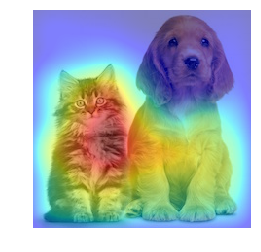

In [6]:
no_GAP_test(model_no_GAP, image_path, 'tabby cat')

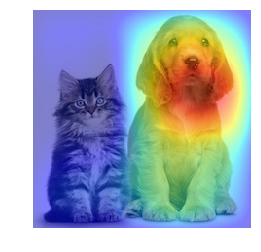

In [7]:
no_GAP_test(model_no_GAP, image_path, 'cocker spaniel')

This looks basically correct. The heatmap for each class is peaked around the corresponding animal. Note, however, that this is far from perfect. In particular, the activations for tabby cat still overlap significantly with the bottom half of the dog. Presumably, this is because the lower half of the animal could conceivably be a cat. Though, interestingly, the converse is not true, perhaps due to the fur markings of the cat being inconsistent with a cocker spaniel, specifically?

What about using excitation backprop? First, let's look at the *non*-contrastive version. Note that the target layer here is 220, which for ResNet-101 is the output of the `conv4_*` block. This is not strictly necessary, though we'll see below that for particularly deep networks propagation all the way back to the input layer seems so not work very well.

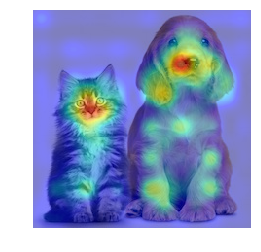

In [8]:
eb_test(model, image_path, 'tabby cat', contrastive=False, target_layer=220)

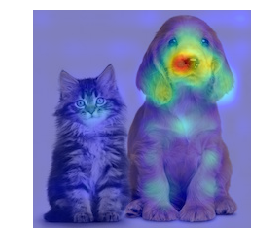

In [9]:
eb_test(model, image_path, 'cocker spaniel', contrastive=False, target_layer=220)

At first blush, this seems *worse*, in some ways. Notice that the main focus is on the faces of the animals, which is by far the most discriminative feature. This is good. However, the attention map for tabby cat has peaks on the faces of the cat and the dog. What if we use the contrastive variation. This should do a better job at locating features which just indicate tabby cat.

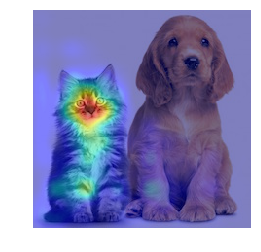

In [10]:
eb_test(model, image_path, 'tabby cat', target_layer=220)

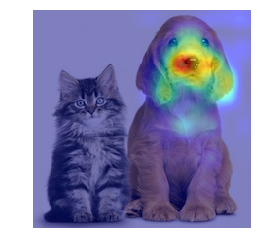

In [11]:
eb_test(model, image_path, 'cocker spaniel', target_layer=220)

Much, much better. Notice now that the performance is superior to that of the naive, no-GAP method. Only the actual cat is highlighted, and the focus is clearly on the elements of the tabby cat that are most discriminative, namely the nose and eyes.

Note also, that this method is more time-consuming. The reasons for this are obvious: we must do a full forward and backward pass.

Next, let's look at a "failure" example.

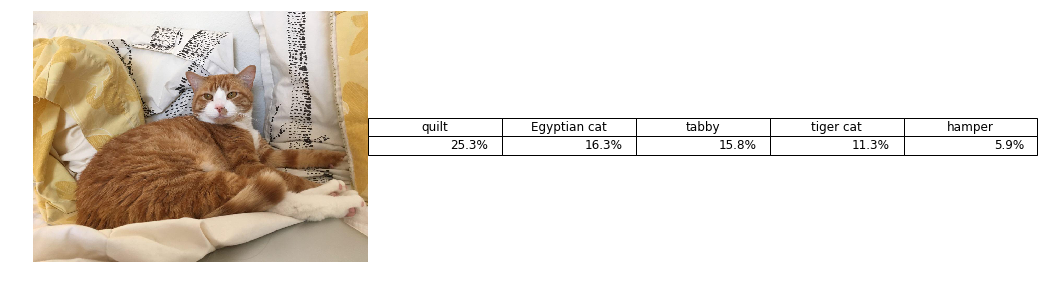

In [12]:
image_path = './data/cute_cat_1.jpg'
imagenet_test(model, image_path)

Personally, I would call this a cat, but the failure is probably just that we have more than one thing in here. Let's investigate.

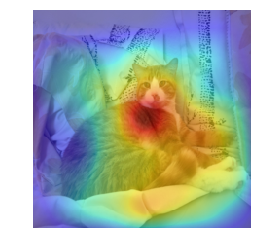

In [13]:
no_GAP_test(model_no_GAP, image_path, 'quilt')

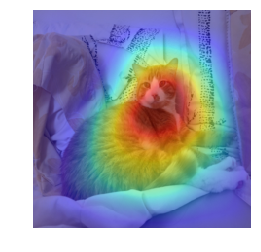

In [14]:
no_GAP_test(model_no_GAP, image_path, 'tabby cat')

Seems wrong. The tabby cat and quilt classes seem triggered by largely the same thing, though we can notice that the spread of the quilt activation is larger, encompassing more of the blanket in addition to Miles. But, let's see if EB gives us a better idea of what is going on.

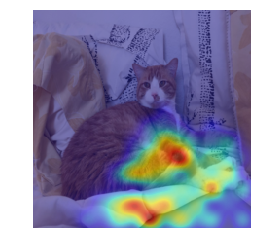

In [15]:
eb_test(model, image_path, 'quilt', target_layer=220)

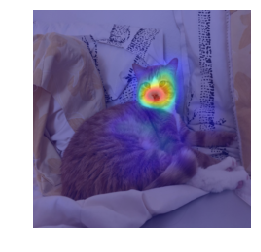

In [16]:
eb_test(model, image_path, 'tabby cat', target_layer=220)

Much better! Notice that the activation map for quilt is still picking up on some parts of the cat, but now is predominantly pointing out the blanket on which he is sitting, while tabby cat once again zeros in almost exclusively on the face of the cat.

Another nice feature of EB is that we can use it with any CNN. Let's look at a VGG network, which has no GAP layer and thus is un-amenable to the simple no-GAP analysis.

In [17]:
model = torchvision.models.vgg16(pretrained=True)
model = model.eval()

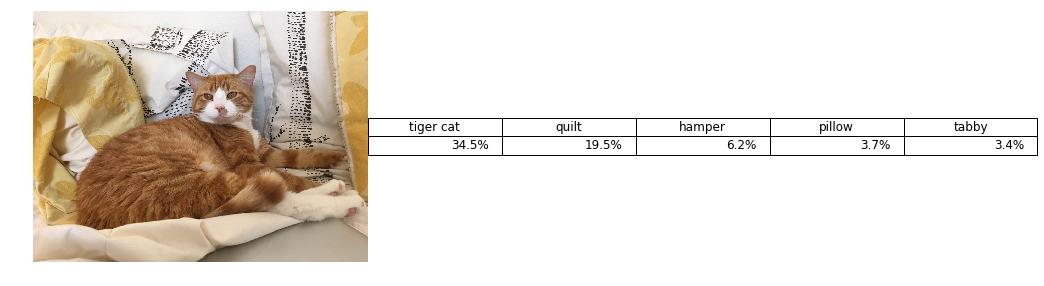

In [18]:
image_path = './data/cute_cat_1.jpg'
imagenet_test(model, image_path)

Funnily enough, the "worse" model did a better job with this particular image, but whatevs. Here we can actually effectively propagate all the way back to the input layer if we want. Notice that the features re much finer, basically outlineing relevant potions of the image.

If we propagate back to an intermediate pooling layer we get a blobbier map, though not as clean as in the case of ResNet-101. This is probably indicating some deficiency in the network itself.

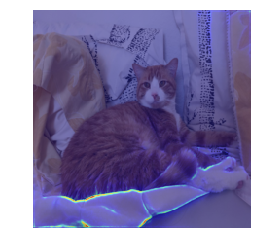

In [19]:
eb_test(model, image_path, 'quilt')

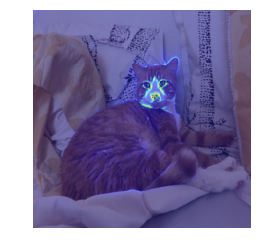

In [20]:
eb_test(model, image_path, 'tabby cat')

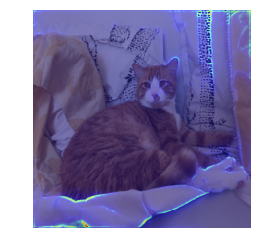

In [21]:
eb_test(model, image_path, 'pillow')

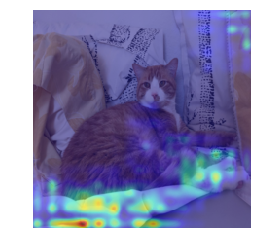

In [22]:
eb_test(model, image_path, 'quilt', target_layer=22)

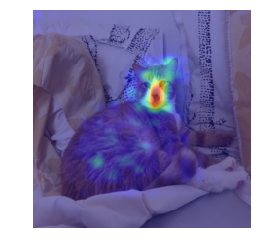

In [23]:
eb_test(model, image_path, 'tabby cat', target_layer=22)

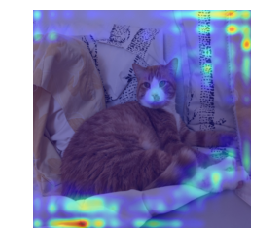

In [24]:
eb_test(model, image_path, 'pillow', target_layer=22)